In [1]:
# Rotating 4D plots and other for Growth of Structure 2021 https://growthofstructure.sites.ucsc.edu/
# Using getdist 1.3+ (getdist.readthedocs.org), esp. 
# https://getdist.readthedocs.io/en/latest/plots.html?highlight=plot_4d#getdist.plots.GetDistPlotter.plot_4d

%matplotlib notebook
#matplotlib.use("Agg") # this seems to have some bugs with rotation output in matplotlib 3.4
import matplotlib.pyplot as plt
import numpy as np
from getdist import plots

<IPython.core.display.Javascript object>


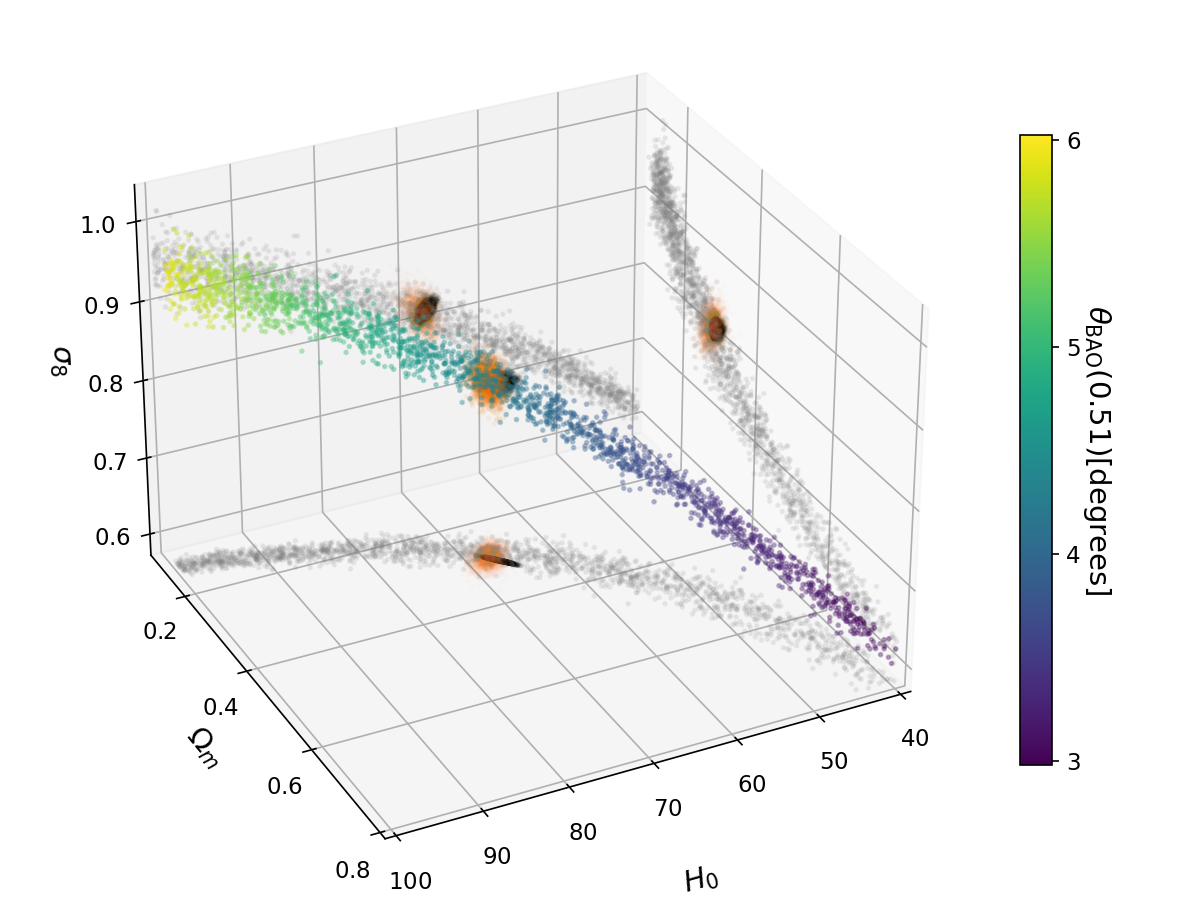

In [2]:
# some options
DES=False
TTTEEE=True
BAO=True
shadows=True
colorbar=True
animate=True
export_mp4=False
filename = None # r'c:\tmp\test.mp4'

priors = 'lenspriors'

omm_lim=(0.1,0.8)
H0_lim=(40,100)
s8_lim=(0.6,1)


if DES:
    omm_lim=(0.1,0.8)
    H0_lim=(40,100)
    s8_lim=(0.6,1.2)
    
if priors == 'DESpriors':
    H0_lim=(55,91)
    omm_lim=(0.1,0.9)
    alpha=0.3
    thin=1


# using public Planck chain grid, change path appropriately
# not actually using getdist to plot here, just manage grid lookup/chain load
g = plots.get_single_plotter(chain_dir=r'c:\tmp\planck\2017\dec17', width_inch=8)

# define a custom derived parameter, here theta_BAO in terms of rdrag and DM051 stored in chains
from getdist.paramnames import ParamInfo
class ThetaBAO(ParamInfo):
    def getDerived(self, par):
        return par.rdrag / par.DM051/np.pi*180

theta_bao = ThetaBAO(name='theta_BAO',label=r'\theta_{\rm BAO}(0.51) {\rm [degrees]}')


roots = ['base_lensing_%s'%priors]
if BAO:
    roots +=  ['base_lensing_BAO_%s'%priors]
if TTTEEE:
    roots +=  ['base_plikHM_TTTEEE_lowl_lowE']

g.plot_4d(roots, ['H0', 'omegam', 'sigma8', theta_bao], cmap='viridis', 
          alpha = [0.3,0.05,0.05], shadow_alpha=[0.1,0.01,0.03], colorbar_args={'shrink': 0.7},
          lims={'H0':(40,100), 'omegam':(0.1, 0.8)}, shadow_color=shadows, 
          compare_colors=['C1','k'], animate=animate, anim_fps=20, mp4_filename=filename)


(2.0, 2501.0)

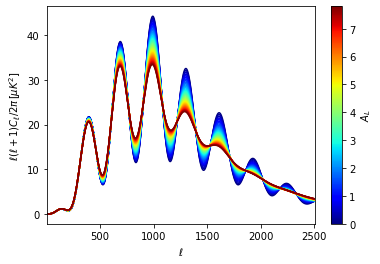

In [3]:
# CAMB parameter plots, need camb installed from github (https://github.com/cmbant/CAMB)
# takes a few minutes or so to run
%matplotlib inline
import camb
import os
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

# Alens

ini = os.path.join(os.path.dirname(camb.__file__),'..','inifiles', 'planck_2018.ini')
pars = camb.read_ini(ini)
cls=[]
Als = np.arange(0,8, 0.2) # increase last number to make run quickly for testing
for Alens in Als:
    pars.Alens=Alens
    pars.set_for_lmax(3000)
    data = camb.get_results(pars)
    cl = data.get_lensed_scalar_cls(CMB_unit='muK')
    cls.append(cl)
lmax=2501

cmap = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=Als[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array(Als)
plt.figure(figsize=(6,4))
for cl,AL in zip(cls,Als):
    plt.plot(np.arange(2, lmax+1), cl[2:lmax+1,1], color=scalarMap.to_rgba(AL))
plt.xlabel('$\ell$')
plt.ylabel('$\ell(\ell+1)C_\ell/2\pi\,[\mu K^2]$')
cb=plt.colorbar(scalarMap)
cb.set_label('$A_L$')
plt.xlim(2,lmax)

<ErrorbarContainer object of 3 artists>

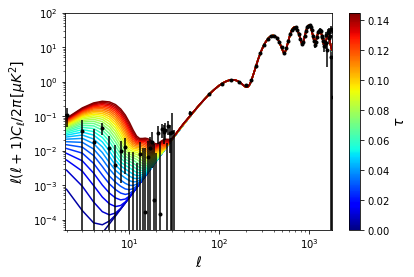

In [4]:
# tau dependence keeping As exp(-2tau) fixed
pars = camb.read_ini(ini)
cls=[]
taus = np.arange(0,0.15, 0.005)
Astau = pars.InitPower.As*np.exp(-2*pars.Reion.optical_depth)
for tau in taus:
    pars.Reion.optical_depth=tau
    pars.InitPower.As = Astau*np.exp(2*tau)
    pars.set_for_lmax(3000)
    data = camb.get_results(pars)
    cl = data.get_lensed_scalar_cls(CMB_unit='muK')
    cls.append(cl)
    
lmax=1801
cmap = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=taus[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array(taus)
plt.figure(figsize=(6,4))
calplanck=1.00044
for cl,tau in zip(cls,taus):
    plt.loglog(np.arange(2, lmax+1), cl[2:lmax+1,1]/calplanck**2, color=scalarMap.to_rgba(tau))
fs=14
plt.xlabel('$\ell$', fontsize=fs)
plt.ylabel('$\ell(\ell+1)C_\ell/2\pi\,[\mu K^2]$', fontsize=fs)
cb=plt.colorbar(scalarMap)
cb.set_label(r'$\tau$', fontsize=fs)
plt.xlim(1.9,lmax)
plt.ylim(5e-5,1e2)
# These files available from the planck PLA
d = np.loadtxt(r'c:\tmp\planck\2017\COM_PowerSpect_CMB-EE-binned_R3.02.txt')
plt.errorbar(d[:,0], d[:,1], d[:,2], d[:,3], fmt='.', color='k')
d = np.loadtxt(r'c:\tmp\planck\2017\COM_PowerSpect_CMB-EE-full_R3.01.txt')
mx=30
plt.errorbar(d[:30,0], d[:30,1], d[:30,2], d[:30,3], fmt='.', color='k',zorder=10000)
#plt.savefig('z://EE_tau.png', dpi=300, bbox_inches='tight')

In [ ]:
# Other parameter plots made with getdist-gui or standard getdist scripts